In [1]:
from data import *
import utils
import warnings
warnings.filterwarnings("ignore")

path = "Data/Dataset"
recs = Recordings(path)

100%|██████████| 52/52 [06:48<00:00,  7.86s/it]


In [2]:
recs.calc_events(force_calculation=False)

In [3]:
savepath = "Data/Dataset_Prepare"
cond = "nod"

save=False

frame_count = 83
time_before = 500
time_after = 200

rec = recs["Pat020"]
for cond in Recording.conditions:
    res = {"Complete": {"All": 0, "Correct": 0, "Incorrect": 0}}
    angles = {"Correct": list(), "Incorrect": list()}
    pat_name = {"Correct": list(), "Incorrect": list()}
    for rec in recs:
        gaze = rec[cond]["Gaze120"]
        scene = rec[cond]["SceneData"]
        scene_infos = scene.loc[scene.Msg.astype(str).apply(lambda x: "target selected" in x), ["Msg", "EyeDataTimestamp"]]

        res[rec.name] = {"All": 0, "Correct": 0, "Incorrect": 0}
        for _, row in scene_infos.iterrows():
            msg = row["Msg"]
            t = row["EyeDataTimestamp"]
            gaze_use = gaze.loc[(gaze["System Timestamp"] > t - time_before) & (gaze["System Timestamp"] < t+time_after)]
            for k in ["Complete", rec.name]:
                res[k]["All"] += 1
                kind = "Correct" if "Correct" in msg else "Incorrect"
                if len(gaze_use) < frame_count:
                    res[k][kind] += 1
                else:
                    gvs = gaze_use[["Local Gaze Direction %s" % x for x in ["X", "Y", "Z"]]].to_numpy()
                    # angles_rec = [utils.angle_between(np.array([0, 0, 1]), x) for x in gvs[:83]]
                    angles_rec = [utils.angle_between(x, y) for x, y in zip(gvs[:(frame_count-1)], gvs[1:frame_count])]
                    angles[kind].append(angles_rec)
                    pat_name[kind].append(rec.name)

    if save:
        for k in ["Correct", "Incorrect"]:
            a = np.array(angles[k])
            p = np.array(pat_name[k])
            np.save(os.path.join(savepath, f"angles_{cond}_{k}_f{frame_count}_b{time_before}_a{time_after}.npy"), a)
            np.save(os.path.join(savepath, f"names_{cond}_{k}_f{frame_count}_b{time_before}_a{time_after}.npy"), p)

(array([], dtype=int64), array([], dtype=int64))

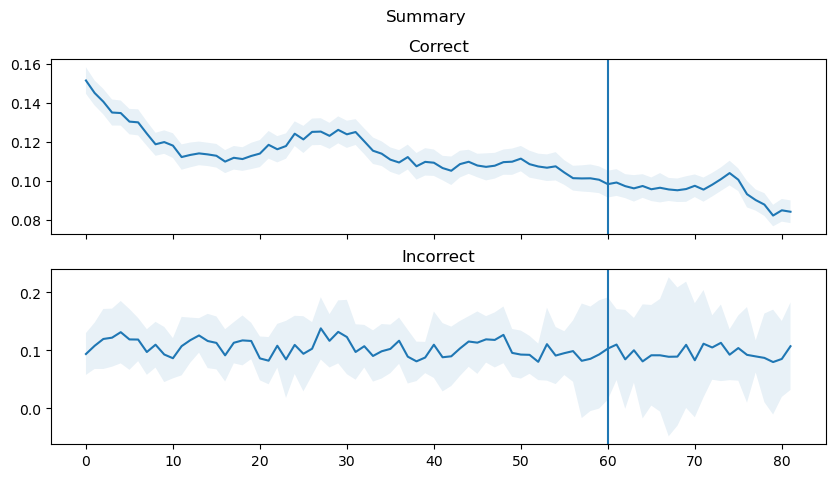

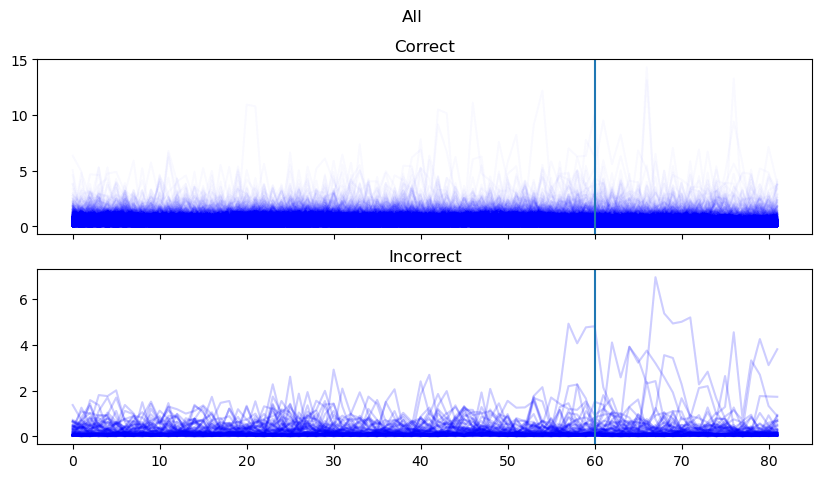

In [5]:
import matplotlib.pyplot as plt

fig_summary, axs_summary = plt.subplots(2, sharex=True, figsize=(10,5))



for i, kind in enumerate(["Correct", "Incorrect"]):
    v = np.array(angles[kind])
    n = v.shape[0]
    means = np.median(v, axis=0)
    stds = np.std(v, axis=0)
    stds = 1.96*stds/np.sqrt(n)
    x = np.arange(len(means))
    axs_summary[i].plot(x, means)
    axs_summary[i].fill_between(x, means-stds, means+stds, alpha=.1)
    axs_summary[i].set_title(kind)
    axs_summary[i].axvline(x=60)
    means
fig_summary.suptitle("Summary")
plt.show()

fig_all, axs_all = plt.subplots(2, sharex=True, figsize=(10, 5))
alpha = {"Correct": .01, "Incorrect": 0.1}

for i, kind in enumerate(["Correct", "Incorrect"]):
    x = np.arange(len(angles[kind][0]))
    for values in angles[kind]:
        axs_all[i].plot(x, values, alpha=alpha[kind], color="blue")
    axs_all[i].axvline(x=60)
    axs_all[i].set_title(kind)
fig_all.suptitle("All")
plt.show()          

# import pandas as pd
# pd.DataFrame(res).transpose()

In [ ]:
import torch

n = int(0.7 * len(angles["Correct"]))
train_data = torch.tensor(angles["Correct"][:n]).type(torch.float)[:, :, None]
test_correct = torch.tensor(angles["Correct"][n:]).type(torch.float)[:, :, None]
test_incorrect = torch.tensor(angles["Incorrect"]).type(torch.float)[:, :, None]

print(f"{train_data.shape=}, {test_correct.shape=}, {test_incorrect.shape=}")

train_data.shape=torch.Size([7984, 82, 1]), test_correct.shape=torch.Size([3422, 82, 1]), test_incorrect.shape=torch.Size([160, 82, 1])


0.8684979544126242 0.1125


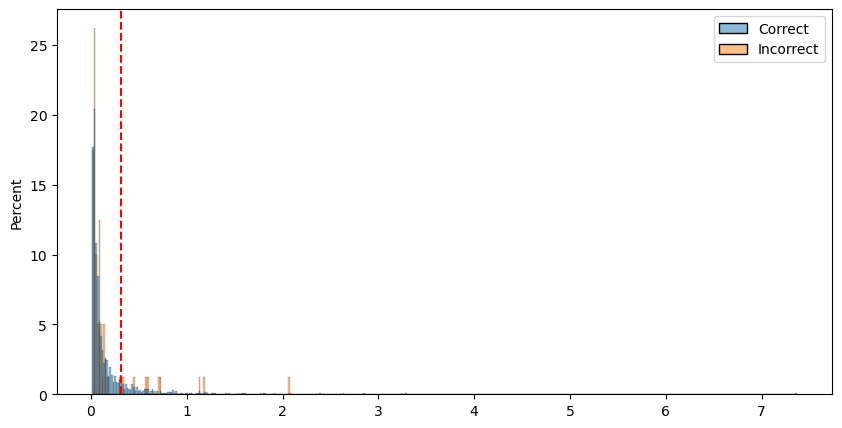

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
baseline = train_data.mean(axis=0)
error_baseline_train = torch.mean((train_data - baseline)**2, dim=(1, 2))
th = np.percentile(error_baseline_train.numpy(), 95)
error_baseline_correct = torch.mean((test_correct - baseline)**2, dim=(1, 2))
error_baseline_incorrect = torch.mean((test_incorrect - baseline)**2, dim=(1, 2))
correct_class = error_baseline_correct < th
incorrect_class = error_baseline_incorrect > th
print(np.mean(correct_class.numpy()), np.mean(incorrect_class.numpy()))

fig, ax = plt.subplots(figsize=(10, 5))

sns.histplot({"Correct": error_baseline_correct.numpy(), "Incorrect": error_baseline_incorrect.numpy()},
             multiple="layer", common_norm=False, stat="percent", ax=ax)
ax.axvline(th, color='red', linestyle='--', label="Threshold")
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_layers=1):
        super(LSTMAutoencoder, self).__init__()
        
        # Encoder LSTM
        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.encoder_fc = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder LSTM
        self.decoder_fc = nn.Linear(latent_dim, hidden_dim)
        self.decoder_lstm = nn.LSTM(hidden_dim, input_dim, num_layers, batch_first=True)
    
    def forward(self, x):
        # Encode
        _, (hidden, _) = self.encoder_lstm(x)
        latent = self.encoder_fc(hidden[-1])
        
        # Decode
        hidden = self.decoder_fc(latent).unsqueeze(0)
        output, _ = self.decoder_lstm(hidden.repeat(x.size(1), 1, 1).permute(1, 0, 2))
        
        return output


In [ ]:
from tqdm import trange
#  Hyperparameters
input_dim = 1       # Number of features (for univariate time series)
hidden_dim = 64     # Number of hidden units in LSTM layers
latent_dim = 16     # Size of the latent vector
num_layers = 1     # Number of LSTM layers
learning_rate = 1e-3
num_epochs = 200

# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = torch.device("cpu")
# Instantiate model, define loss and optimizer
model = LSTMAutoencoder(input_dim, hidden_dim, latent_dim, num_layers).to(device)
criterion = nn.MSELoss()  # Mean Squared Error for reconstruction loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Dummy training data (replace with your own time series)
# Shape: (batch_size, sequence_length, input_dim)
# train_data = torch.randn(100, 30, input_dim)  # 100 sequences of 30 time steps

train_data = train_data.to(device)

# Training loop
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    output = model(train_data)
    
    # Compute reconstruction loss
    loss = criterion(output, train_data)
    loss.backward()
    optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [1/200], Loss: 0.3307
Epoch [2/200], Loss: 0.3038
Epoch [3/200], Loss: 0.2801
Epoch [4/200], Loss: 0.2593
Epoch [5/200], Loss: 0.2409
Epoch [6/200], Loss: 0.2246
Epoch [7/200], Loss: 0.2101
Epoch [8/200], Loss: 0.1973
Epoch [9/200], Loss: 0.1859
Epoch [10/200], Loss: 0.1758
Epoch [11/200], Loss: 0.1670
Epoch [12/200], Loss: 0.1593
Epoch [13/200], Loss: 0.1526
Epoch [14/200], Loss: 0.1469
Epoch [15/200], Loss: 0.1422
Epoch [16/200], Loss: 0.1384
Epoch [17/200], Loss: 0.1353
Epoch [18/200], Loss: 0.1328
Epoch [19/200], Loss: 0.1307
Epoch [20/200], Loss: 0.1288
Epoch [21/200], Loss: 0.1270
Epoch [22/200], Loss: 0.1251
Epoch [23/200], Loss: 0.1230
Epoch [24/200], Loss: 0.1209
Epoch [25/200], Loss: 0.1187
Epoch [26/200], Loss: 0.1164
Epoch [27/200], Loss: 0.1142
Epoch [28/200], Loss: 0.1122
Epoch [29/200], Loss: 0.1104
Epoch [30/200], Loss: 0.1090
Epoch [31/200], Loss: 0.1080
Epoch [32/200], Loss: 0.1075
Epoch [33/200], Loss: 0.1076
Epoch [34/200], Loss: 0.1081
Epoch [35/200], Loss: 0

In [ ]:
# Dummy test data (mix of normal and anomalous sequences)
# test_data = torch.randn(20, 30, input_dim)  # Replace with your test dataset



# Set model to evaluation mode
model.eval()

# Compute reconstruction errors
with torch.no_grad():
    reconstructed_train = model(train_data)
    mse_error_train = torch.mean((reconstructed_train - train_data)**2, dim=(1, 2))
    reconstructed_correct = model(test_correct)
    mse_error_correct = torch.mean((reconstructed_correct - test_correct) ** 2, dim=(1, 2))  # Mean error per sequence
    reconstructed_incorrect = model(test_incorrect)
    mse_error_incorrect = torch.mean((reconstructed_incorrect - test_incorrect) ** 2, dim=(1, 2))

# Set a threshold based on training or validation errors (e.g., 95th percentile)


In [ ]:
mse_error_incorrect.shape

torch.Size([160])

In [ ]:
th = np.percentile(mse_error_train.numpy(), 95)

correct_class = mse_error_correct < th
incorrect_class = mse_error_incorrect > th
print(np.mean(correct_class.numpy()), np.mean(incorrect_class.numpy()))

0.864406779661017 0.0875


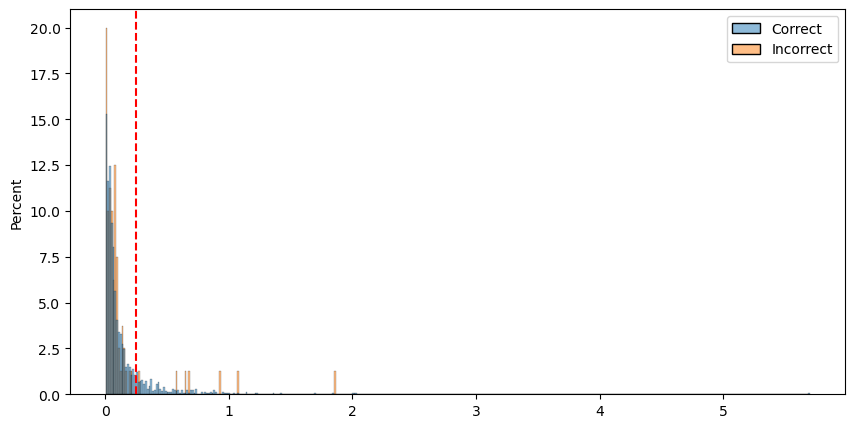

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 5))

sns.histplot({"Correct": mse_error_correct.numpy(), "Incorrect": mse_error_incorrect.numpy()},
             multiple="layer", common_norm=False, stat="percent", ax=ax)
ax.axvline(th, color='red', linestyle='--', label="Threshold")
plt.show()

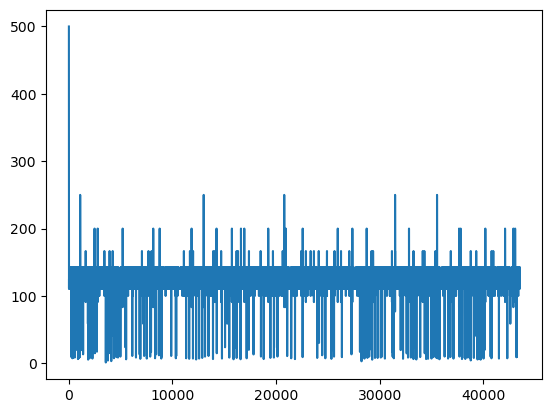

Median 125.0
Mean 120.2092058392301
Min TDiff 2
Median TDiff 8.0
Max TDiff 802


In [ ]:
import matplotlib.pyplot as plt

gaze120 = recs["Pat047"]["nod"]["Gaze120"]
t = gaze120.loc[gaze120.Message=="gaze sample", "System Timestamp"].to_numpy()
tDiff = np.diff(t)
fps = 1/(tDiff*0.001)
fps = fps[np.where(~np.isinf(fps))]
plt.plot(fps)
plt.show()
print("Median", np.median(fps))
print("Mean", np.mean(fps))
print("Min TDiff", tDiff.min())
print("Median TDiff", np.median(tDiff))
print("Max TDiff", tDiff.max())